# Assignment 1
#### Authors:

* Nikolaj Bach Meineche, s204103
* Rebekka Wätzold Høgh Madsen, s204113
* Magnus Waldemar Hoff Harder, s204117

## Formulia
### Github repo link
https://github.com/Rebekka-M/02467_CSS

### Contribution table

Contribution (%) | Nikolaj (s204103) | Rebekka (s204113) | Magnus (s204117) 
 :- | :-: | :-: | :-: 
 Part 1 | 34% | 33% | 33% 
 Part 2 | 33% | 34% | 33% 
 Part 3 | 33% | 33% | 34% 

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import tqdm

## Part 1: Using web-scraping to gather data
Gather the list of researchers that have joined the most important scientific conference in Computational Social Science in 2019.

You can find the programmes of the 2019 edition at the links below:
* Oral presentations: https://2019.ic2s2.org/oral-presentations/
* Poster presentations: https://2019.ic2s2.org/posters/

### 1.1 Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it

In [2]:
# Oral:
oral_link = 'https://2019.ic2s2.org/oral-presentations/'
oral_r = requests.get(oral_link)
oral_soup = BeautifulSoup(oral_r.text)

# Find the chair persons for each section
chairs = [i.text.replace('<em>Chair:','').replace('Chair: ','') for i in oral_soup.find_all("em")]

# Define list for speakers and edge case wording found through quality check of final list
oral_speakers = []
edge_cases = ['No Presentation', 'No presentation', 'No Presentation (cancelled)',  'No presentation (cancelled)',
              'Analyzing and Countermeasures', 'Policy Documents','and Twitter', 'UK and German Elections', 'collaboration',
              'and impact', 'cultural and scientific careers','Places and People: strategies',
              'limitations and trade-offs in the physical and digital worlds', 'which nodes should have the last word in multiplayer ultimatum bargaining?',
              'Stable Exchange Networks through Quenched Merchant Location and Idiosyncratic Trading Costs','Connecting Degree Programs from Individuals’ Choices',
              '000 Leagues Under the City','family and neighbor network','and Security']

for i in oral_soup.find_all('p')[3:len(chairs)+3]:

    # Split the program string into a list by looking at the the time stamps in the program
    program = re.split('(?:[0-9])(?:[0-9]):(?:[0-9])(?:[0-9]) – (?:[0-9])(?:[0-9]):(?:[0-9])(?:[0-9]) – ',
                   i.text)[1:]
    
    # Loop through the program list to find and split the speakers 
    for presentation in program:
        for speaker in presentation.split(','):
            # Remove space if there is a space at the front of the speaker name
            if speaker[0] == ' ':
                speaker = speaker[1:]
            
            # if the speaker name is longer then 20 characters, that is a pretty good indication that the string includes the title of the paper
            # remove the paper title
            if len(speaker) > 20:
                speaker = speaker.split('.')[0]
                speaker = speaker.split('–')[0]
            
            # Edge case handling
            if ': ' in speaker:
                speaker = speaker.split(': ')[-1]
            
            # Remove space at the end if present
            if speaker[-1] == ' ':
                speaker = speaker[:-1]
            
            # Last edgecase handling
            if speaker not in edge_cases:
                if speaker == 'James P':
                    speaker = 'James P. Gleeson'
                if speaker == '(Moved to 3D Text Analysis) Ivan Smirnov':
                    speaker = 'Ivan Smirnov'
                if speaker == 'Alex Pentland. Fair':
                    speaker = 'Alex Pentland'
                
                # Save to speakers list 
                oral_speakers.append(speaker)

In [3]:
# Poster:
poster_link = 'https://2019.ic2s2.org/posters/'
poster_r = requests.get(poster_link)
poster_soup = BeautifulSoup(poster_r.text)

# Define list for speakers and edge case titles found through quality check of final list
poster_speakers = []
edge_cases = ['Structure and Evolution of the Network of Countries Signing Global Environmental Treaties',
              'Evolution of the Network of Countries Signing Global Environmental Treaties',
              'Social capital at IC2S2: A network analysis of the conference participants between 2015-2018.',
              'Invisible college in large co-authorship networks – iterative sampling approach',
              'Founders Dynamics: Interpersonal Relationships and Between-Team Interaction in Early Startups',
              'Bio, psycho or social – Discursive framing of depression in online health communities',
              'Evolution of Employment in the United States: A Longitudinal Study of Job Polarisation',
              'Tipping Points in Polarized Networks']

# Loop through the posters found on the webpage
for poster in poster_soup.find('div', class_="col-md-8 page-content-wrap").find_all('li'):

    # Cut the titles
    speakers = poster.text.split('\xa0')[0]
    speakers = speakers.split('\n')[0]

    # Check that the "found speaker" is not one of the edge cases
    if speakers not in edge_cases:
        
        # Split the speakers string into a speaker list
        for speaker in speakers.split(','):

            # Remove first letter if it is a space
            if speaker[0] == ' ':
                speaker = speaker[1:]
            
            # Separate speakers that are separated by an and
            if 'and' in speaker:
                for sp in speaker.split(' and '):
                    # Save to speakers list
                    poster_speakers.append(sp)
            else:
                # Save to speakers list
                poster_speakers.append(speaker)

In [4]:
# Combine the lists

researchers = chairs + oral_speakers + poster_speakers

print("Total researcher entries at the 2019 IC2S2 conference:", len(researchers))

Total researcher entries at the 2019 IC2S2 conference: 1211


### 1.2 How many unique researchers you got in 2019?

In [5]:
unique_researchers = list(set(researchers))
print("Number of unique researchers found at the 2019 IC2S2 conference:", len(unique_researchers))

Number of unique researchers found at the 2019 IC2S2 conference: 922


### 1.3 Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice?

Using commas for seperating presenters worked in the oral presentations, however separating these names from the titles of the papers proved troublesome in some cases. These paper names often contains a marker such as a '.' or a '-' to signify the beginning of the title. But we also had to avoid splitting up names of presenters who also has a '.' or a '-' as part of their names such as "Juan Mateos-Garcia". Therefore we made an assumption: If names are longer than 20 characters, that is a pretty good indication that the string includes the title of the paper. This allows us to split up the names of the presenters and the titles of the papers with quite few final edgecases.

This is not a perfect heuristic, as we ran into some edge-cases of long names or titles that included a comma in the title. These edge cases where to the best of our abilities listed by going through the output list.

## Part 2: Getting data from the Semantic Scholar API

1. Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find:
* their aliases, their name
* their papers, where for each paper we want to retain:
    * title, abstract, the year of publication, the externalIds (this is because there are universal identifiers for scientific works called DOI that we can use across platforms), s2FieldsOfStudy the fields of study, citationCount the number of times that this paper was cited

2. Create three dataframe to store the data you have collected.
* Author dataset: in the author dataset, one raw is one unique author, and each row contains the following information:
    * authorId: (str) the id of the author
    * name: (str) the name of the author
    * aliases: (list) the aliases of the author
    * citationCount: (int) the total number of citations received by an author
    * field: (str) the s2FieldsOfStudy that occurs most times across an author's papers (you should first obtain the category for each s2FieldsOfStudy)
* Paper dataset: in the paper dataset, one row is one unique paper, and each row contains the following information:
    * paperId: (str) the id of the paper
    * title: (str) the title of the paper
    * year: (int) the year of publication
    * externalId.DOI: (str) the DOI of the paper
    * citationCount: (int) the number of citations
    * fields: (list) the fields included in the paper (you should first obtain the category for each s2FieldsOfStudy)
    * authorIds: (list) this is a list of author Ids, including all the authors of this paper that are in our author dataset
* Paper abstract dataset: in the paper abstract dataset, one row is one unique paper, and each row contains the following information:
    * paperId: (str) the id of the paper
    * abstract: (str) the abstract of the paper
(Note: we keep the abstract separate to keep the size of files more manageable)

### 2.1 Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.

In [6]:
import pickle as pkl

with open('Exercises/all_unique_speakers.pkl', 'rb') as f:
    all_unique_researchers = pkl.load(f)


# Let me know if you prefer to use more then just the 2019 researchers mentioned in Part 1
print("Number of researchers used for analysis (incl. all collaborators):",len(all_unique_researchers))

Number of researchers used for analysis (incl. all collaborators): 2210


### 2.2 Share the code you have used to solve the exercise above

Note that the code has been shared in a non-executable format as execution takes several hours due to the call-rate of the API.

``` python # Define author IDs list for later searches
authorIDs = []

# For each author
found = 0
for author in all_unique_researchers:
        # Try to find the author on Semantic Scholar
        names = author.split(" ")
        first, last = names[0], names[-1]
        response = requests.get(f'https://api.semanticscholar.org/graph/v1/author/search?query={first.lower()}+{last.lower()}')
        found += 1
        
        # If author is found, save author ID
        query = response.json()
        for API_value in query['data']:
            authorIDs.append(API_value['authorId'])

with open('Exercises/authorIDs.pkl', 'wb') as f:
     pkl.dump(authorIDs, f)


```python
#Define dataframes as specified by assignment
AuthorData = pd.DataFrame(columns=['AuthorID', 'Name', 'Aliases', 'CitationCount','Field'])
PaperData = pd.DataFrame(columns=['paperId', 'title', 'abstract', 'year','externalIds','citationCount', 'authors','s2FieldsOfStudy'])
AbstractData = pd.DataFrame(columns=['PaperID', 'Abstract'])

```python
# Get AuthorData
i = 0

# Contains the author IDs saved for all to ovoid overwriting
with open('Exercises/authorIDs_final.pkl', 'rb') as f:
     authorIDs = pkl.load(f)

# For each authorID find query authors and append to the authordata and paperData frame
batch = []
for ID in authorIDs:
    if len(batch) < 100:
        batch.append(ID)
    else:
        IDs_query = {"ids": batch}
        response = requests.post(f'https://api.semanticscholar.org/graph/v1/author/batch?fields=authorId,name,externalIds,aliases,citationCount,affiliations,papers.paperId,papers.title,papers.year,papers.externalIds,papers.citationCount,papers.abstract,papers.authors,papers.s2FieldsOfStudy',
                                 json=IDs_query)
        Query = response.json()

        for Query_author in Query:
            AuthorData = pd.concat([AuthorData,
                                    pd.DataFrame.from_dict([{'AuthorID': Query_author['authorId'], 'Name': Query_author['name'], 'Aliases': Query_author['aliases'], 'CitationCount': Query_author['citationCount'], 'Field': None}])])
            Papers = pd.DataFrame.from_dict(Query_author['papers'])
            PaperData = pd.concat([PaperData, Papers])



```python
# Find DOI
dois = []

for i in range(len(PaperData)):
    try:
        dois.append(PaperData.externalIds.iloc[i]['DOI'])
    except:
        dois.append('')

PaperData['externalId.DOI'] = dois

```python
# Find field of authors
fields = []

#For each author in author dataframe
for authorId in AuthorData.AuthorID:
    # create a mask
    mask = []

    # Loop through all paper and all authors in all papers to check if the author has written the paper
    for authors in PaperData.authors:
        temp = []
        for i in range(len(authors)):
            try:
                temp.append(int(authors[i]['authorId']))
                # mask.append(any([int(authors[i]['authorId']) == authorId for i in range(len(authors))]))
            except:
                temp.append(False)
        
        mask.append(any(temp))
    
    fields_temp = []
    for field in PaperData.s2FieldsOfStudy[mask]:
        try:
            fields_temp.append(field[0]['category'])
        except:
            pass
    fields.append(max(set(fields_temp), key = fields_temp.count))

AuthorData['Field'] = fields

Considering the API only allows for certaint querys at each time from an IP Adress. We have run the code Mutiple times at different timepoints iteration over the ID's Array to optain the papers from the first 3900 ID's out of ~33,000

```python
# Clean Data and Save data due to long runtime
AbstractData = PaperData[['paperId', 'abstract']]
PaperData = PaperData.drop(['abstract'], axis=1)

# save as excel files, so we can load for further analysis without needing to re-run the above code
AuthorData.to_excel('AuthorData.xlsx')
PaperData.to_excel('PaperData.xlsx')
AbstractData.to_excel('AbstractData.xlsx')

### 2.3 How long is your final Author dataframe? How long is your final Paper dataframe?

In [7]:
AuthorData = pd.read_excel('AuthorData.xlsx', index_col=0)
PaperData = pd.read_excel('PaperData.xlsx',index_col=0)
PaperData.externalIds = [eval(PaperData.externalIds.iloc[i]) for i in range(len(PaperData))]
PaperData.authors = [eval(PaperData.authors.iloc[i]) for i in range(len(PaperData))]
PaperData.s2FieldsOfStudy = [eval(PaperData.s2FieldsOfStudy.iloc[i]) for i in range(len(PaperData))]

print(f"Length of Author Dataframe is {len(AuthorData)}")
print(f"Length of Paper Dataframe is {len(PaperData)}")

Length of Author Dataframe is 3900
Length of Paper Dataframe is 77547


## Part 3: Law of large numbers
As we have discussed in the lecture, one impact of heavy tails is that sample averages can be poor estimators of the underlying mean of the distribution. To understand this point better, recall the Law of Large Numbers. Consider a sample of IID variables $X_1,…,X_n$ from the same distribution $F$ with finite expected value $\mathbb{E}|X_i|=\int xF(dx)=\mu$.

According to the law, the mean of the sample $\bar{X}_n:=\frac{1}{n}\sum_{i=1}^{n}X_i$ satisfies
$$\bar{X}_n\rightarrow \mu\quad \text{as}\quad n \rightarrow \infty$$

This basically tell us that if we have a large enough sample, the sample mean will converge to the population mean.

The condition that $\mathbb{E}|X_i|$ is finite holds in most cases but can fail if the distribution $F$ is very heavy tailed. Further, even when $\mathbb{E}|X_i|$ is finite, the variance of a heavy tailed distribution can be so large that the sample mean will converge very slowly to the population mean. We will look into this in the following exercise.

### 3.1-3.9: Gaussian Distribution
1. Sample **N=10,000** data points from a Gaussian Distribution with parameters $\mu=0$ and $\sigma=4$, using the `np.random.standard_normal()` function. Store your data in a numpy array $\mathbf{X}$
2. Create a figure. Plot the distribution of the data in $\mathbf{X}$
3. Compute the cumulative average of $\mathbf{X}$. Store the result in an array.
4. In a similar way, compute the cumulative standard error of $\mathbf{X}$. Store the result in an array
5. Compute the values of the distribution mean and median.
6. Create a figure.
    * Plot the cumulative average computed in point 3. as a line plot (where the x-axis represents the size of the sample considered, and the y-axis is the average).
    * Add errorbars to each point in the graph with width equal to the standard error of the mean.
    * Add a horizontal line corresponding to the distribution mean
7. Compute the cumulative median of $\mathbf{X}$. Store the result in an array
8. Create a figure.
    * Plot the cumulative median computed in point 7. as a line plot (where the x-axis represent the size of the sample considered, and the y-axis is the average)
    * Add a horizontal line corresponding to the distribution median.
    * *Optional*: Add errorbars to your median line graph, with width equal to the standard error of the median. You can compute the standard error of the median via bootstrapping.

In [8]:
# Sample a gaussian distribution
n = 10000
mu = 0
sigma = 4

X_gaussian = np.random.normal(size=n, loc = mu, scale = sigma)

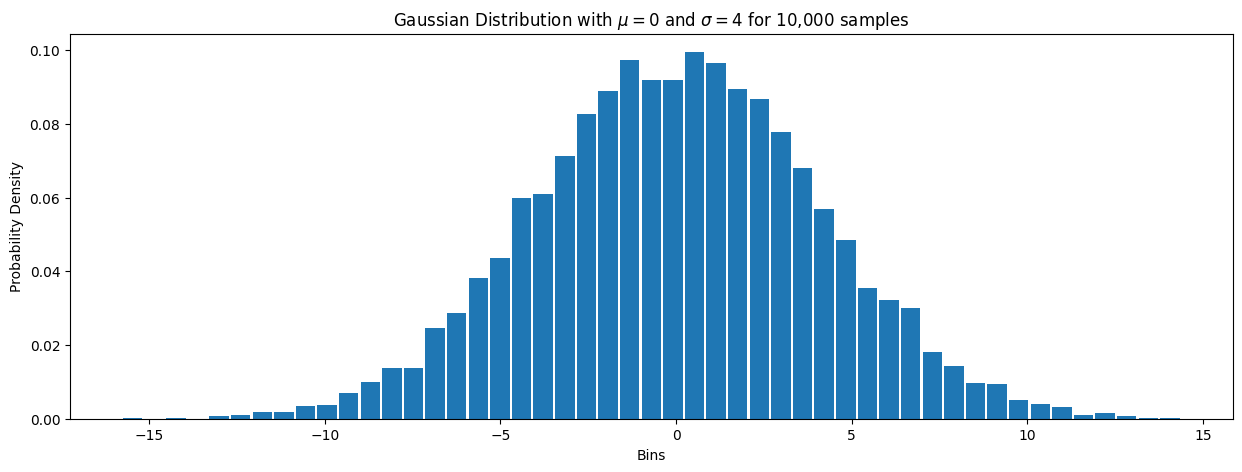

In [9]:
# Plot the distribution of X_gaussian
bins = np.linspace(min(X_gaussian), max(X_gaussian), 50)
hist, edges = np.histogram(X_gaussian, bins=bins, density = True)
x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize = (15,5))
ax.bar(x, hist, width = width * 0.9)
ax.set_title("Gaussian Distribution with $\mu=0$ and $\sigma=4$ for 10,000 samples")
ax.set_xlabel("Bins")
ax.set_ylabel("Probability Density")
plt.show()

In [10]:
# Compute the cumulative average of X_gaussian
cum_average = np.array([np.mean(X_gaussian[:i]) for i in range(1, n+1)])

# Compute the cumulative standard error of X_gaussian
cum_std = np.array([np.std(X_gaussian[:i]) for i in range(1, n+1)])
cum_se = cum_std/np.sqrt(np.arange(1,n+1))

# Compute the cumulative median of X_gaussian
cum_median = np.array([np.median(X_gaussian[:i]) for i in range(1, n+1)])


[Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution) mean and median formulas for the Gaussian distribution:

Median and mean are the same, $\mu$

In [11]:
distribution_mean = mu
distribution_median = mu

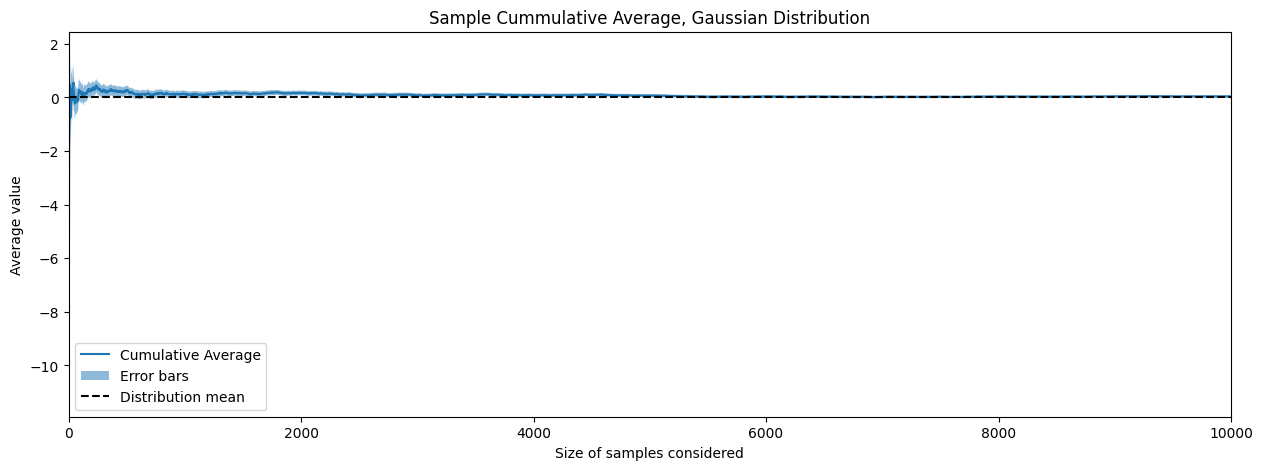

In [12]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_average, label = "Cumulative Average")
ax.fill_between(np.arange(1,n+1), cum_average - cum_se, cum_average + cum_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_mean, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution mean")
ax.set_title("Sample Cummulative Average, Gaussian Distribution")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Average value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

The bootstrap code takes two hours to execute and has thus been placed in a non-executable cell:
``` python
# bootstrapping for standard error of the median
boot_median_std = np.zeros(n)
boot_median_se = np.zeros(n)
b = 1000

for sample_size in tqdm.tqdm(np.arange(1,3000)):
    boot_median_std[sample_size-1] = np.std(np.median(np.random.choice(X_gaussian, size=sample_size*b, replace=True).reshape(sample_size,b),axis=1))
    boot_median_se[sample_size-1] = boot_median_std[sample_size-1]/np.sqrt(sample_size)

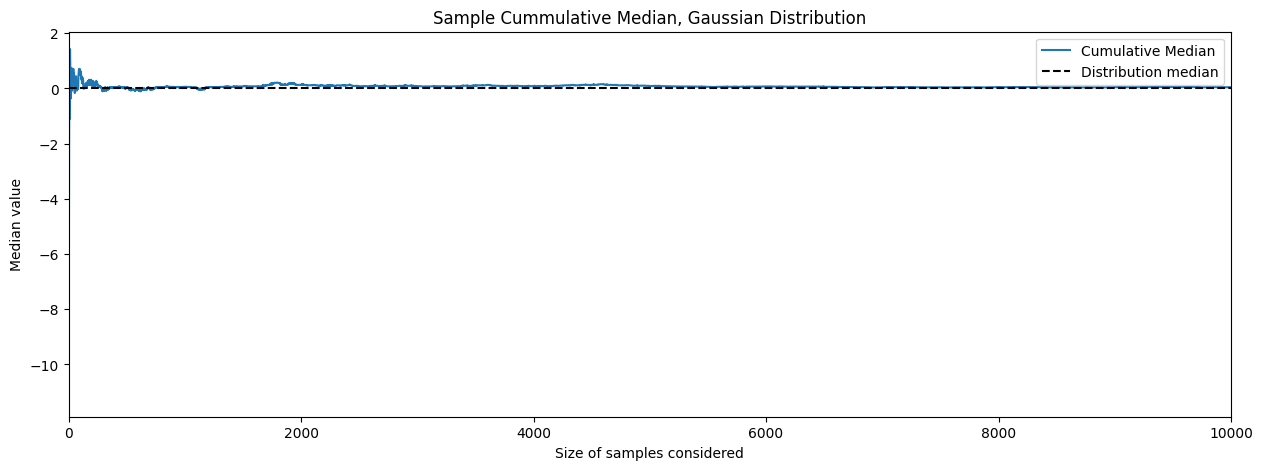

In [13]:
# plotting
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_median, label = "Cumulative Median")
ax.hlines(y = distribution_median, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution median")
ax.set_title("Sample Cummulative Median, Gaussian Distribution")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Median value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

### 3.9-3.10
9. Now sample **N=10,000** data points from a Pareto Distribution with parameters $x_m=1$ and $\alpha=0.5$ using the `np.random.pareto()` function, and store it in a numpy array.
10. Repeat poits 3.2 to 3.8 for the Pareto Distribution sample computed in point 9.

In [14]:
n = 10000
alpha = 0.5
xm = 1
X_pareto = np.random.pareto(a = alpha, size = n)

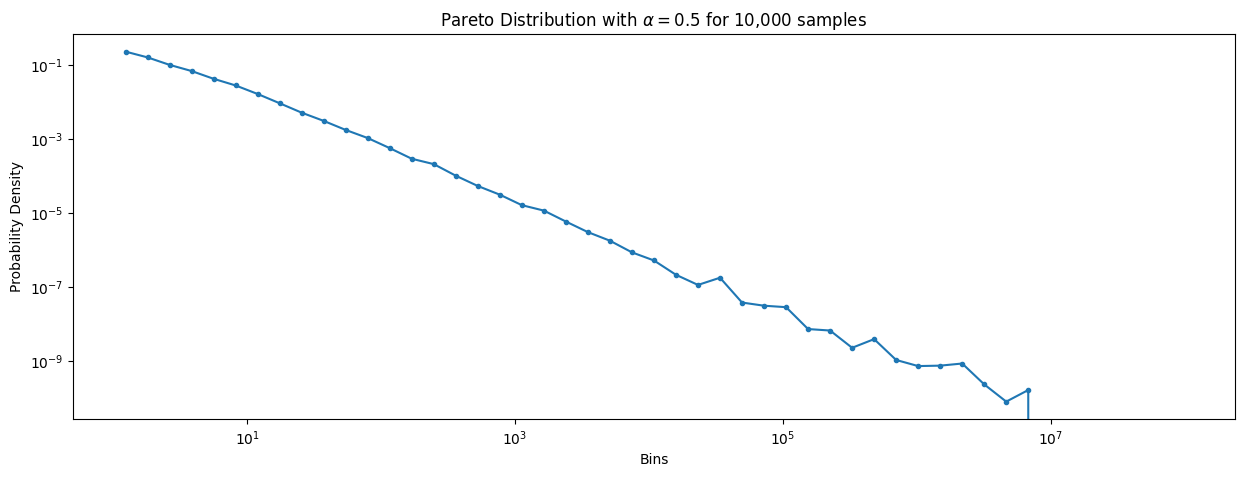

In [15]:
# Plot the distribution of X_pareto
bins = np.logspace(0, np.log10(max(X_pareto)), 50)
hist, edges = np.histogram(X_pareto, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(x, hist, marker = ".")
ax.set_title(r"Pareto Distribution with $\alpha=0.5$ for 10,000 samples")
ax.set_xlabel("Bins")
ax.set_ylabel("Probability Density")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [16]:
# Compute the cumulative average of X_pareto
cum_average = np.array([np.mean(X_pareto[:i]) for i in range(1, n+1)])

# Compute the cumulative standard error of X_pareto
cum_std = np.array([np.std(X_pareto[:i]) for i in range(1, n+1)])
cum_se = cum_std/np.sqrt(np.arange(1,n+1))

# Compute the cumulative median of X_pareto
cum_median = np.array([np.median(X_pareto[:i]) for i in range(1, n+1)])

[Wikipedia](https://en.wikipedia.org/wiki/Pareto_distribution) mean and median formulas for the Pareto Distribution:
$$\bar{x}=\begin{cases}\infty & \text{for }\alpha\leq 1 \\ \frac{\alpha x_m}{\alpha-1} & \text{for }\alpha > 1 \end{cases}$$

$$\text{median}=x_m\sqrt[\alpha]{2}$$

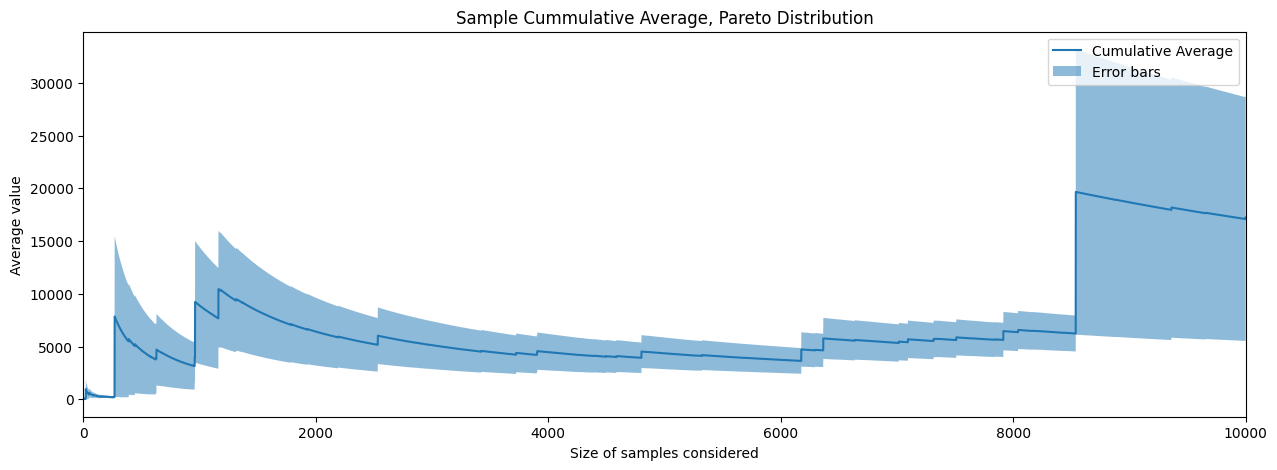

In [17]:
# Calculate distribution mean of X_pareto = infinity

# Plot cumulative mean, error-bars, and distribution mean of X_pareto
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_average, label = "Cumulative Average")
ax.fill_between(np.arange(1,n+1), cum_average - cum_se, cum_average + cum_se, label = "Error bars", alpha=0.5)
ax.set_title("Sample Cummulative Average, Pareto Distribution")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Average value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

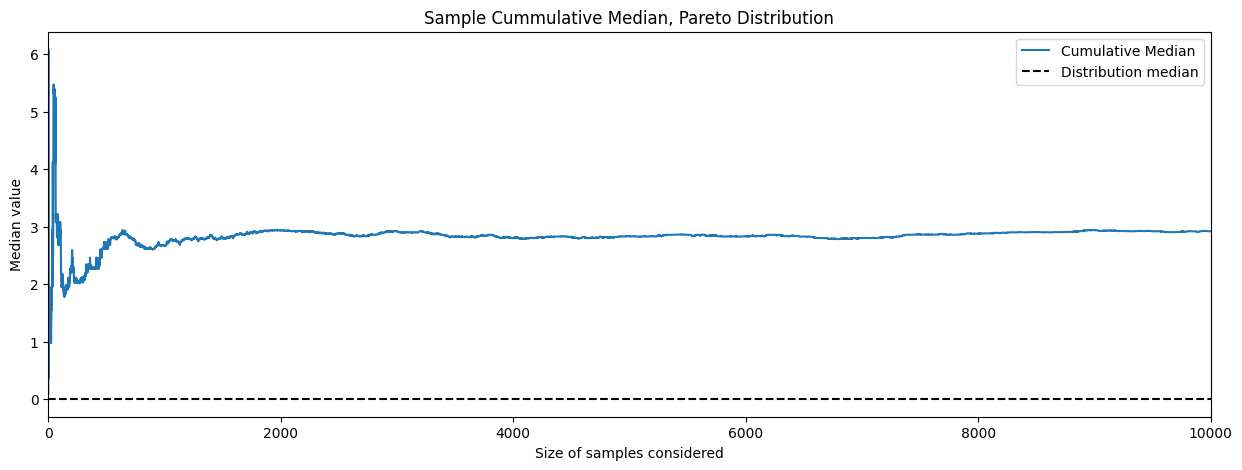

In [18]:
distributions_median = xm*np.sqrt(2)
# plotting
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_median, label = "Cumulative Median")
# ax.fill_between(np.arange(1,n+1), cum_median - 1.96*boot_median_se, cum_median + 1.96*boot_median_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_median, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution median")
ax.set_title("Sample Cummulative Median, Pareto Distribution")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Median value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

## 3.11-3.12
11. Now sample **N=10,000** data points from a lognormal distribution with parameters $\mu=0$ and $\sigma=4$ using `np.random.standard_normal()` function, and store it in a numpy array.
12. Repeat points 3.2 to 3.8 for the Lognormal Distribution sample computed in point 11

In [19]:
n = 10000
mu = 0
sigma = 4
X_lognormal = np.random.lognormal(mean=mu, sigma=sigma, size=n)

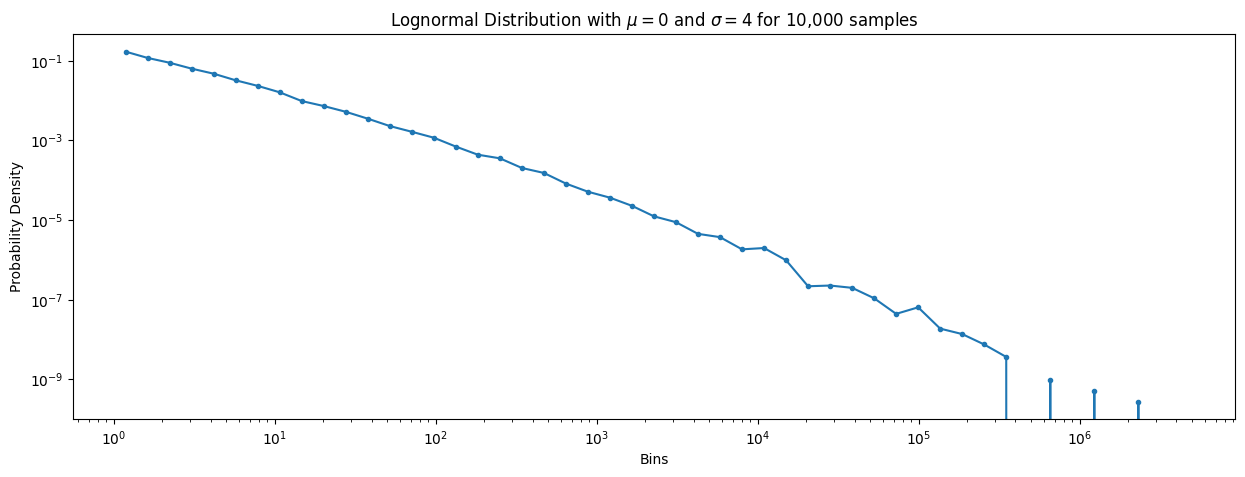

In [20]:
# Plot the distribution of X_pareto
bins = np.logspace(min(X_lognormal), np.log10(max(X_lognormal)), 50)
hist, edges = np.histogram(X_lognormal, bins=bins, density = True)
x = (edges[1:]+edges[:-1])/2

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(x, hist, marker = '.')
ax.set_title("Lognormal Distribution with $\mu=0$ and $\sigma=4$ for 10,000 samples")
ax.set_xlabel("Bins")
ax.set_ylabel("Probability Density")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [21]:
# Compute the cumulative average of X_lognormal
cum_average = np.array([np.mean(X_lognormal[:i]) for i in range(1, n+1)])

# Compute the cumulative standard error of X_lognormal
cum_std = np.array([np.std(X_lognormal[:i]) for i in range(1, n+1)])
cum_se = cum_std/np.sqrt(np.arange(1,n+1))

# Compute the cumulative median of X_lognormal
cum_median = np.array([np.median(X_lognormal[:i]) for i in range(1, n+1)])

[Wikipedia](https://en.wikipedia.org/wiki/Log-normal_distribution) mean and median formulas for the Lognormal Distribution:
$$\text{mean}=\exp\left(\mu + \frac{\sigma^2}{2}\right)$$

$$\text{median}=\exp\left(\mu\right)$$

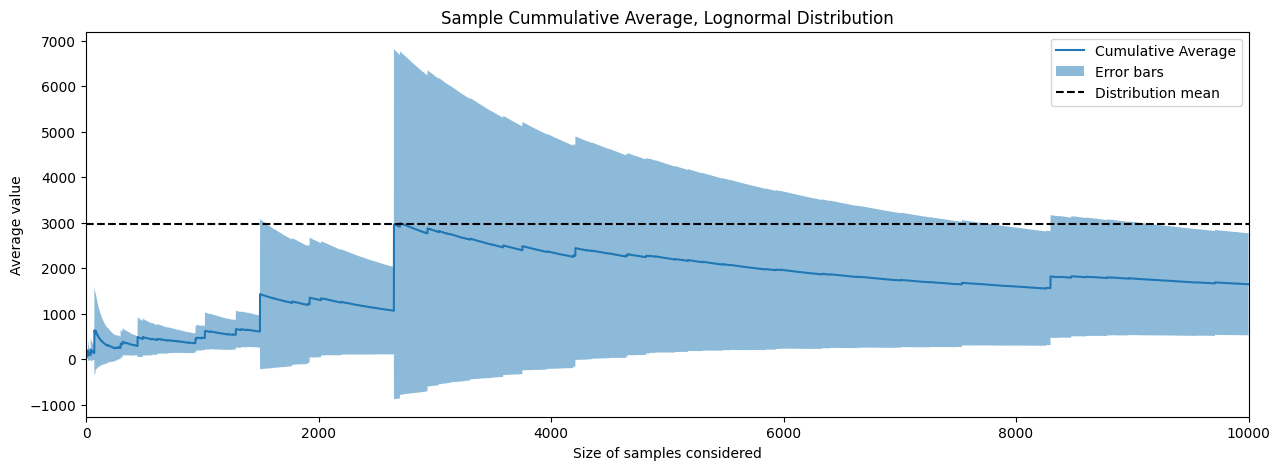

In [22]:
# Calculate distribution mean of X_lognormal
distribution_mean = np.exp(0 + sigma**2/2)

# Plot cumulative mean, error-bars, and distribution mean of X_lognormal
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_average, label = "Cumulative Average")
ax.fill_between(np.arange(1,n+1), cum_average - 1.96*cum_se, cum_average + 1.96*cum_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_mean, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution mean")
ax.set_title("Sample Cummulative Average, Lognormal Distribution") # Not sure if error bars should include the 1.96, so it becomes the 95% CIs
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Average value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

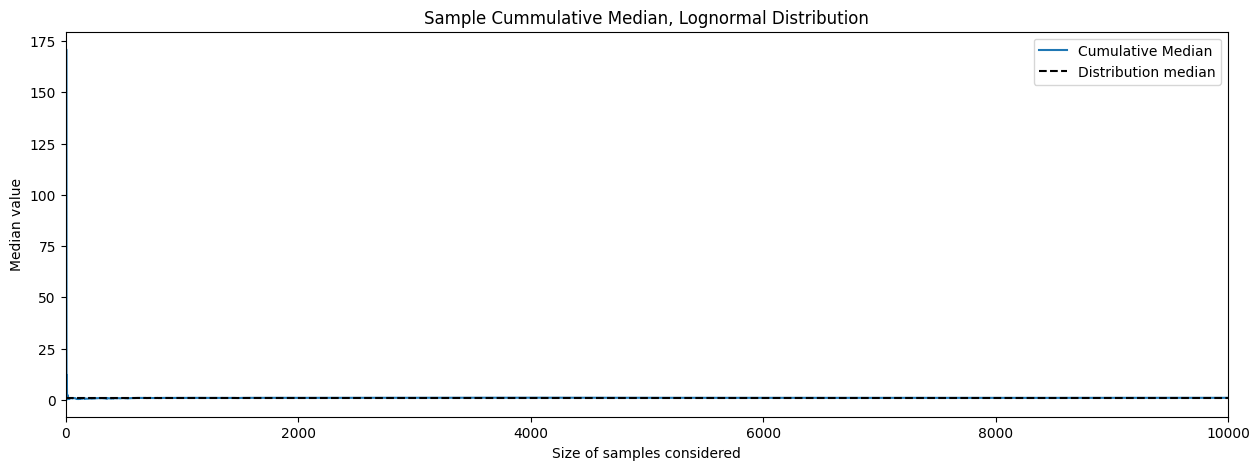

In [23]:
# plot cumulative median, error bars, and distribution median of X_lognormal
distribution_median = np.exp(mu)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_median, label = "Cumulative Median")
# ax.fill_between(np.arange(1,n+1), cum_median - 1.96*boot_median_se, cum_median + 1.96*boot_median_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_median, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution median")
ax.set_title("Sample Cummulative Median, Lognormal Distribution")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Median value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

## 3.13-3.14
13. Now, consider the array collectig the citations of papers from 2019 you created in Week3, Exercise 2, point 1. First, compute the mean and median number of citations for this population. Then, extract a random sample of **N=10,000** papers.
14. Repeat points 3.2-3.4, 3.5-3.8 above for the paper citation sample prepared in point 13.

In [24]:
X_papers = pd.read_excel("PaperData.xlsx",index_col=0).reset_index()
X_papers.head()

,index,paperId,title,year,externalIds,citationCount,authors,s2FieldsOfStudy
0,0,18d7f27c86ca935199b79556171d5e68cd40e7be,Comparing Online and Offline Political Support,2022.0,"{'DOI': '10.1111/spsr.12524', 'CorpusId': 2491...",0,"[{'authorId': '41096303', 'name': 'L. Brandenb...",[]
1,1,125d45f2d7e253d803eddcada79d0f1bfa1d082f,Social media data in affective science,2021.0,"{'DOI': '10.4324/9781003024583-18', 'CorpusId'...",0,"[{'authorId': '103932770', 'name': 'Max Peller...",[]
2,2,fae1e6a4fea5562f33e1388223ebae44fb167ff5,Why Online does not Equal Offline: Comparing O...,2021.0,"{'DOI': '10.31235/osf.io/j4fp6', 'CorpusId': 2...",1,"[{'authorId': '41096303', 'name': 'L. Brandenb...","[{'category': 'Business', 'source': 's2-fos-mo..."
3,3,33169f9e7abc2aafb344ea4b589d88e587709858,An agent-based model of multi-dimensional opin...,2020.0,"{'MAG': '3088216215', 'DOI': '10.1063/5.000752...",10,"[{'authorId': '22446549', 'name': 'Simon Schwe...","[{'category': 'Economics', 'source': 's2-fos-m..."
4,4,a2fc362384a1d59901b3ee7377b4ca4c2d50a0be,An agent-based model of multi-dimensional opin...,2020.0,"{'ArXiv': '2003.05929', 'DBLP': 'journals/corr...",6,"[{'authorId': '22446549', 'name': 'Simon Schwe...","[{'category': 'Economics', 'source': 's2-fos-m..."


In [25]:
# Calculate means and medians for population of citation count
X_citation = np.array(X_papers["citationCount"])

distribution_mean = np.mean(X_citation)
distribution_median = np.median(X_citation)

print(f'The mean of the population is {distribution_mean}.')
print(f'The median of the population is {distribution_median}.')

The mean of the population is 22.21606251692522.
The median of the population is 2.0.


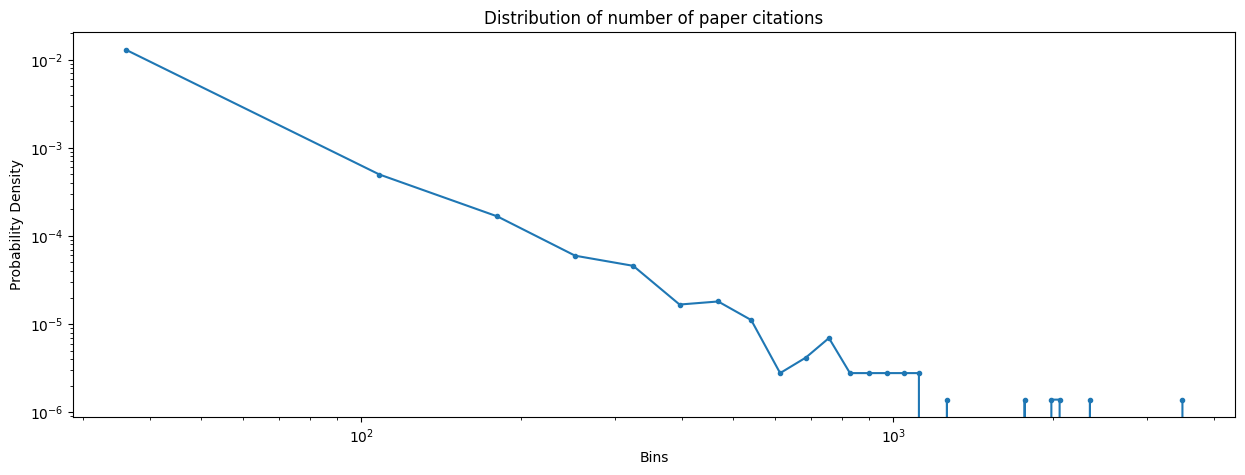

In [26]:
# Select 10.000 at random
n = 10000
np.random.seed(0)
X = np.random.choice(X_citation,n,replace=False)


# Plot the distribution
bins = np.linspace(0, max(X), 50)
hist, edges = np.histogram(X, bins=bins, density = True)
x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(x, hist, marker = '.')
ax.set_title("Distribution of number of paper citations")
ax.set_xlabel("Bins")
ax.set_ylabel("Probability Density")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


In [27]:
# Compute the cumulative average of citations
cum_average = np.array([np.mean(X[:i]) for i in range(1, n+1)])

# Compute the cumulative standard error of citations
cum_std = np.array([np.std(X[:i]) for i in range(1, n+1)])
cum_se = cum_std/np.sqrt(np.arange(1,n+1))

# Compute the cumulative median of citations
cum_median = np.array([np.median(X[:i]) for i in range(1, n+1)])

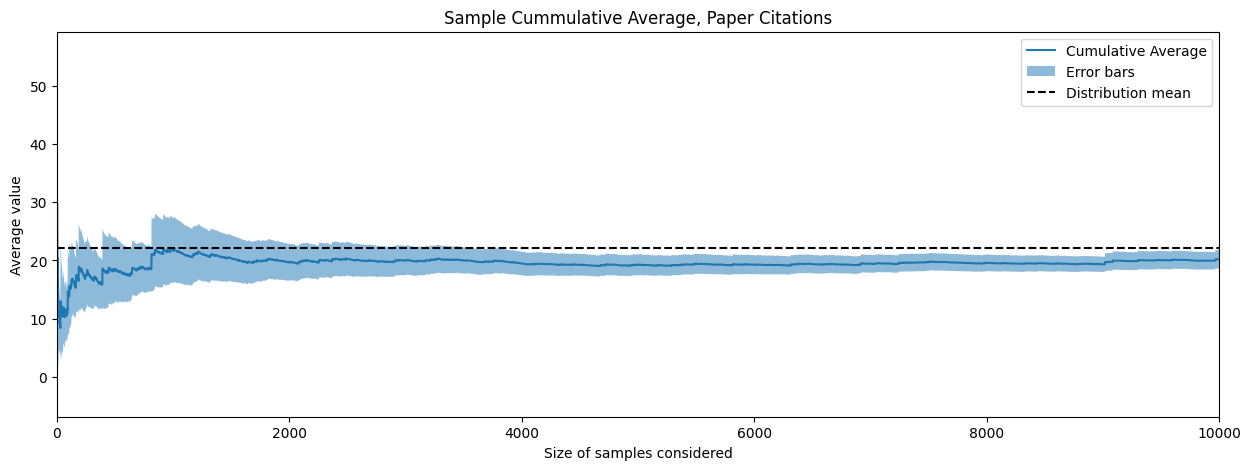

In [28]:
# Plot cumulative mean, error-bars, and distribution mean of citations
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_average, label = "Cumulative Average")
ax.fill_between(np.arange(1,n+1), cum_average - 1.96*cum_se, cum_average + 1.96*cum_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_mean, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution mean")
ax.set_title("Sample Cummulative Average, Paper Citations") # Not sure if error bars should include the 1.96, so it becomes the 95% CIs
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Average value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

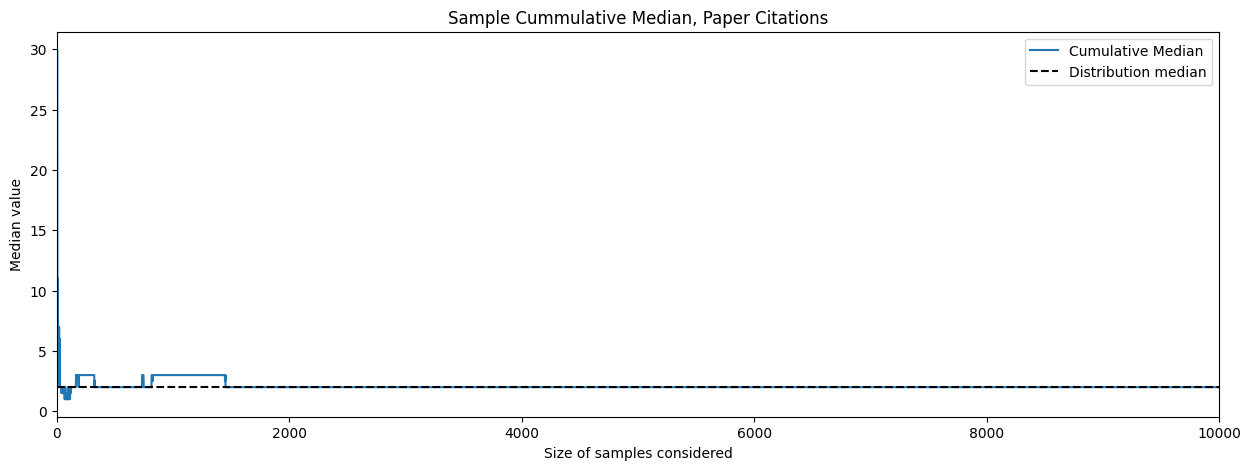

In [29]:
# plot cumulative media, and distribution median of paper citations

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(np.arange(1,n+1), cum_median, label = "Cumulative Median")
# ax.fill_between(np.arange(1,n+1), cum_median - 1.96*boot_median_se, cum_median + 1.96*boot_median_se, label = "Error bars", alpha=0.5)
ax.hlines(y = distribution_median, xmin=0, xmax = n, colors = 'black', linestyle = 'dashed', label = "Distribution median")
ax.set_title("Sample Cummulative Median, Paper Citations")
ax.set_xlabel("Size of samples considered")
ax.set_ylabel("Median value")
ax.set_xlim(0,n)
ax.legend()
plt.show()

### Answer the following questions:
#### Compare the evolution of the cumulative average for the Gaussia, Pareto, and Lognormal distribution. What do you observe? Would you expect these results? Why?

Compared to the other two, the Gaussian cumulative average starts out a little bit random, but then quick "quiets" down, as points are more likely to lie close to the true mean. This also means that with enough samples, no outlying sample will have a big impact on the cumulative mean. This is why the mean turns out stable after the first few initial samples. However, the pareto and log normal distributions do not share the same properties. In these distributions it is clear that only a few samples out of thousands of samples can quite significantly impact the cumulative mean. This is however to be expected, as both of these distributions are heavy-tailed. This means that they are affected by the Big Jump Principle. This is what can be observed when the variance and mean suddenly rises from what appears like a single sample.

#### Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more useful in the different cases?

For the Gaussian distribution the mean and median are theoretically equal since points are spread evenly around the mean, therefore with enough samples they should converge towards the same value. 

For the other two distributions the mean and median express clearly different distribution metrics. Firstly, the medians are quite a bit lower than the means. Secondly, the medians in these population somewhat reflect what the mean could have been if the Big Jump outliers had not been present. In other words, the medians in these population explain what the most common values are, which can be useful in e.g economics when you wish to analyse how much most people earn. This doesn't mean that the mean is useless in these scenarios, however the mean doesn't always represent the entirity of the population.

In conclusion when analysing distribution types, mean and median represents different properties of the underlying distribution. Having access to only one would not yield a fullfilling picture of the distribution. Comparing the two can to some extend explain the spread within the sample. Fx. if mean and median are roughly the same one would expect a normal distribution, while if the the median is higher/lower than the mean the distribution could be ligth/heavy tailed distribution. 

#### Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?

Considering the distribution plot of the citation count, it roughly follows a straight line on log-scaled axis, which implies that the distribution is heavy-tailed. This can also be seen since the median of the distribution is way lower than the mean. This implies that a small amount of papers account for a large part of the total citation count. This aligns with the Pareto principle which is common in many scientific areas. Additionally, it aligns well with our normal understanding of authorship of academic papers. One would generally assume that a small group of authors are responsible for the bulk of papers being written, while the majority of academic authors have only published a handful of papers.

#### What do you think are the main take-home messages of this exercise?

When working with real life data, it is important to consider which distribution you are dealing with. Sometimes we assume a normal distribution, but this is not always the case, as many real world examples follow e.g Pareto distributions, especially in Computational Social Science.

It is also important to notice that you don't actually need the entire population to get a good understanding of it. A sample of a couple of thousands can usually be enough to accurately represent the population.